# THE SOURCE

In [1]:
"""The purpose of this report is to do an analyzation of the Donald Trump Twitter account and design a predictive model
    to predict the exact source of an individual tweet from the Donald Trump account. The result of the analysis will then be used
    as a factor in a seperate model design to show the effect of Donal Trump's Twitter on the financial markets."""

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
import string
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

%matplotlib inline

C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read in files
trump_16 = pd.read_json('tweets_2016.json')
trump_17 = pd.read_json('tweets_2017.json')
trump_16.sort_index(ascending=False, inplace = True)
trump_17.sort_index(ascending =False, inplace = True)
trump = trump_16.append(trump_17, ignore_index=True)
trump.shape

(5884, 8)

# Preprocessing and Feature Addition

The dataset consists of 5884 individual tweets and from Midnight Janbuary 1, 2016 to 11:00 p.m. on September 17, 2017. There are 8 different characteristics to every observation

1) Time created 

2) Number of Likes 

3) Id of Individual Tweet 

4) Id of User tweet replies to(if applicable) 

5) Tweet is Retweet(if applicable)

6) Number of times tweet was retweeted

7) Source

8) Tweet

The text of the data will have to preprocessed and features will need to be added for a complete analyzation to take place.

Let's start with an overall investigation of the dataset. 

In [3]:
#preprocess trump tweets by removing all twitter special characters, leaving only the words of the text.
trump.text = trump.text.apply(lambda x: re.sub(r"&\S+", "", x, flags=re.MULTILINE))
trump.text = trump.text.apply(lambda x: re.sub(r"@\S+", "", x, flags=re.MULTILINE))
trump.text = trump.text.apply(lambda x: re.sub(r"http\S+", "", x, flags=re.MULTILINE))
trump.text = trump.text.apply(lambda x: re.sub(r'\d+', '',x, flags=re.MULTILINE))

In [4]:
trump.head()

created_at  favorite_count              id_str  \
0 2016-01-01 00:44:14            6735  682723973449289728   
1 2016-01-01 03:25:27            8581  682764544402440192   
2 2016-01-01 05:18:23            9143  682792967736848384   
3 2016-01-01 06:07:28            8258  682805320217980928   
4 2016-01-01 06:08:06            7490  682805477168779264   

   in_reply_to_user_id_str  is_retweet  retweet_count               source  \
0                      NaN       False           2108  Twitter for Android   
1                      NaN       False           3460   Twitter for iPhone   
2                      NaN       False           3434   Twitter for iPhone   
3                      NaN       False           1948   Twitter for iPhone   
4                      NaN       False           2721  Twitter for Android   

                                                text  
0  I will be on  live,  with members of my family...  
1                       HAPPY NEW YEAR  THANK YOU!    
2                             #HappyNewYearAmerica!   
3  Happy New Year from #MarALago! Thank you to my...  
4  " Hillary said she was in a "Fog of War" as ex...

In [5]:
trump.tail()

created_at  favorite_count              id_str  \
5879 2017-09-15 22:58:30           44914  908827394856947712   
5880 2017-09-15 23:54:00           71686  908841360131743744   
5881 2017-09-16 22:40:23           22322  909185223887347712   
5882 2017-09-16 22:59:06           13697  909189931154771968   
5883 2017-09-16 23:04:03           11893  909191177810915328   

      in_reply_to_user_id_str  is_retweet  retweet_count              source  \
5879                      NaN       False          11823  Twitter for iPhone   
5880                      NaN       False          17473        Media Studio   
5881                      NaN       False           4691  Twitter for iPhone   
5882                      NaN       False           3347  Twitter for iPhone   
5883                      NaN       False           2504  Twitter for iPhone   

                                                   text  
5879  We will defend our people, our nations and our...  
5880  HAPPY th BIRTHDAY to the  The American people ...  
5881  A great deal of good things happening for our ...  
5882  Attorney General Bill Shuette will be a fantas...  
5883  I will be in Huntsville, Alabama, on Saturday ...

In [6]:
trump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5884 entries, 0 to 5883
Data columns (total 8 columns):
created_at                 5884 non-null datetime64[ns]
favorite_count             5884 non-null int64
id_str                     5884 non-null int64
in_reply_to_user_id_str    35 non-null float64
is_retweet                 5884 non-null bool
retweet_count              5884 non-null int64
source                     5884 non-null object
text                       5884 non-null object
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 327.6+ KB


The is_reply_to_user_id column only has 35 values, the id_str column has no repeat values and is not of use for analyzation or predicitve modeling. Both columns can be dropped from the dataset.

In [7]:
trump.drop('id_str', axis=1, inplace=True)
trump.drop('in_reply_to_user_id_str', axis=1, inplace=True)

In [8]:
trump[trump['is_retweet']==True].count()

created_at        377
favorite_count    377
is_retweet        377
retweet_count     377
source            377
text              377
dtype: int64

Less than 5% of the tweets are something Donald Trump has retweeted, but will leave it in the dataset to see what types of things he retweets.

In [9]:
trump[trump['is_retweet']==True].text[0:5]

26     RT  So proud to be out on the campaign trail w...
91     RT  Explosive Trump attack on HRC, Bill, Monic...
167    RT  REUTERS ROLLING:  TRUMP %, CRUZ .%, BUSH ....
187    RT      obvious to all that he raised some GRE...
239     RT  I look forward to being on  with  at :pmET. 
Name: text, dtype: object

Now lets investigate the target vartiable, the source of each individual tweet.

In [10]:
trump['source'].value_counts()

Twitter for iPhone     3221
Twitter for Android    2116
Twitter Web Client      358
Twitter Ads              96
Media Studio             65
Twitter for iPad         22
Instagram                 2
TweetDeck                 2
Mobile Web (M5)           1
Periscope                 1
Name: source, dtype: int64

Over 95% of the dataset comes one of three sources and any investigation can focus solely on Twitter for IPhone, Twitter for Android and Twitter Web Client.

In [11]:
# Training dataframe with observations from three relevan sources only
trump = trump[trump.source != 'Twitter Ads']
trump = trump[trump.source != 'Media Studio']
trump = trump[trump.source != 'Twitter for iPad']
trump = trump[trump.source != 'TweetDeck']
trump = trump[trump.source != 'Instagram']
trump = trump[trump.source != 'Periscope']
trump = trump[trump.source != 'Mobile Web (M5)']

In [12]:
# Check the data types for the remaining columns
trump.dtypes

created_at        datetime64[ns]
favorite_count             int64
is_retweet                  bool
retweet_count              int64
source                    object
text                      object
dtype: object

The final step in the preprocessing of the dataset is to make the index a datetime index

In [13]:
#Make dataframe a datetime index
trump.index=pd.DatetimeIndex(trump['created_at'])
trump.drop('created_at', axis = 1, inplace =True)
trump.shape

(5695, 5)

So our preprocessed dataset consist of 5695 observations and 5 characteristics for each observation

# Data Analyzation


Let's start by generating any new features that might be impoprtant factors in the source classification.

In [14]:
# Obtain the hour of the day and the day of the week for each observation and add them as features to the dataframe
trump['hours'] = trump.index.hour
trump['weekday'] = trump.index.weekday_name

## Natural Language Processing

In [15]:
from nltk.corpus import stopwords

# get english stop words
english = stopwords.words('english')

Specific packages within Python allow us to analyze written text for both its Meta and Text attributes.


### Meta Attributes:

Meta attributes include:

1) Number of words per tweet

2) Number of unique words in tweet

3) Number of characters in tweet

4) Number of stopwords

5) Number of punctuation

6) Number of upper case words

7) Number of title case words

8) Average length of word

In [16]:
# Number of words in tweet
trump['num_words'] = trump['text'].apply(lambda x: len(str(x).split()))

# Number of unique word per tweet
trump['num_unique_words'] = trump['text'].apply(lambda x: len(set(str(x).split())))

# Number of characters in tweet
trump['num_char'] = trump['text'].apply(lambda x: len(str(x)))

# Number of stop words
trump['num_stops'] = trump['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in english]))

# Number of puncuation in tweet
trump['num_punc'] = trump['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Number of upper case words
trump['num_upper'] = trump['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of title case words in tweet
trump['num_title'] = trump['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Average length of word
# trump['avg_len'] = trump['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))



In [17]:
trump.head()

favorite_count  is_retweet  retweet_count  \
created_at                                                       
2016-01-01 00:44:14            6735       False           2108   
2016-01-01 03:25:27            8581       False           3460   
2016-01-01 05:18:23            9143       False           3434   
2016-01-01 06:07:28            8258       False           1948   
2016-01-01 06:08:06            7490       False           2721   

                                  source  \
created_at                                 
2016-01-01 00:44:14  Twitter for Android   
2016-01-01 03:25:27   Twitter for iPhone   
2016-01-01 05:18:23   Twitter for iPhone   
2016-01-01 06:07:28   Twitter for iPhone   
2016-01-01 06:08:06  Twitter for Android   

                                                                  text  hours  \
created_at                                                                      
2016-01-01 00:44:14  I will be on  live,  with members of my family...      0   
2016-01-01 03:25:27                       HAPPY NEW YEAR  THANK YOU!        3   
2016-01-01 05:18:23                             #HappyNewYearAmerica!       5   
2016-01-01 06:07:28  Happy New Year from #MarALago! Thank you to my...      6   
2016-01-01 06:08:06  " Hillary said she was in a "Fog of War" as ex...      6   

                    weekday  num_words  num_unique_words  num_char  num_stops  \
created_at                                                                      
2016-01-01 00:44:14  Friday         25                24       122         12   
2016-01-01 03:25:27  Friday          5                 5        28          0   
2016-01-01 05:18:23  Friday          1                 1        22          0   
2016-01-01 06:07:28  Friday         16                16        86          8   
2016-01-01 06:08:06  Friday         25                24       125         11   

                     num_punc  num_upper  num_title  
created_at                                           
2016-01-01 00:44:14         7          6          5  
2016-01-01 03:25:27         1          5          0  
2016-01-01 05:18:23         2          0          0  
2016-01-01 06:07:28         3          0          4  
2016-01-01 06:08:06         7          2          7

Let's plot some of the new variables to see any correlation. Obviously, we will start with difference in the number of words in a Tweet depending on the source.

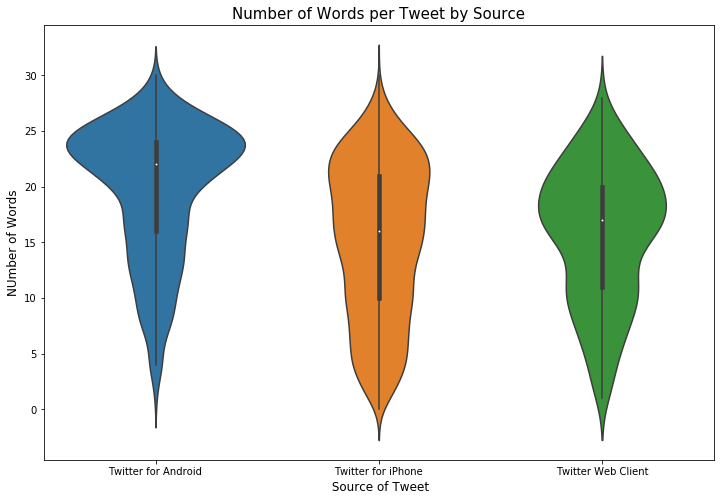

In [18]:
plt.figure(figsize=(12,8))
sns.violinplot(x='source', y= 'num_words', data= trump)
plt.xlabel(' Source of Tweet', fontsize=12)
plt.ylabel('NUmber of Words', fontsize=12)
plt.title('Number of Words per Tweet by Source', fontsize=15)

There is a significantly higher mean with the android source versus the other two but the distibutions of the sources is consistent with each other. Basically, this graph says that the android source was used much more for Tweets ranging from 20-30 words. i.e. longer tweets.

Next let's investigate the amount of punctuation in each by source

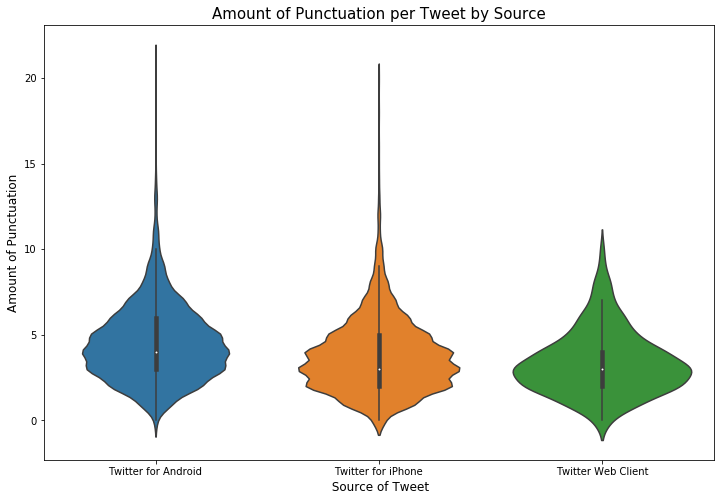

In [19]:
plt.figure(figsize=(12,8))
sns.violinplot(x=trump['source'], y= 'num_punc', data= trump)
plt.xlabel(' Source of Tweet', fontsize=12)
plt.ylabel('Amount of Punctuation', fontsize=12)
plt.title('Amount of Punctuation per Tweet by Source', fontsize=15)

There are some outliers within the Android and iPhone sources but the Web Client is normally distributed. The outliers can be dealt with by taking the log of the Android and iPhone punctuation values.

In [20]:
trump['num_punc']= trump['num_punc'].apply(lambda x: np.log(x))

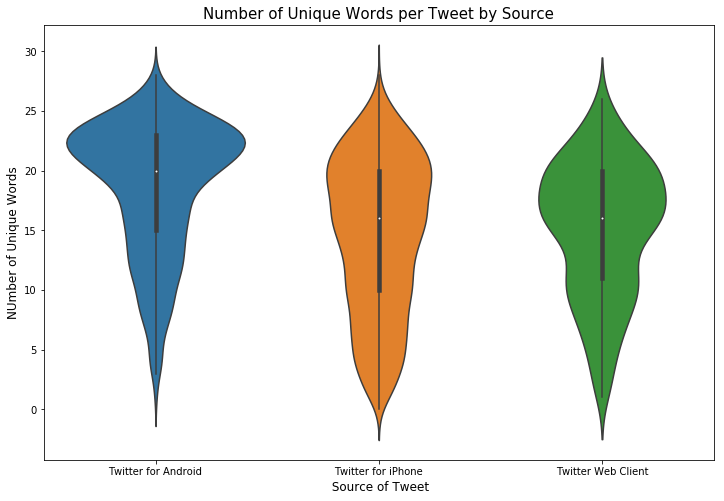

In [21]:
plt.figure(figsize=(12,8))
sns.violinplot(x=trump.source, y= 'num_unique_words', data= trump)
plt.xlabel(' Source of Tweet', fontsize=12)
plt.ylabel('NUmber of Unique Words', fontsize=12)
plt.title('Number of Unique Words per Tweet by Source', fontsize=15)

As expected there is some obvious correlation between number of words and the number of unique words. The graphs are nearly identical.

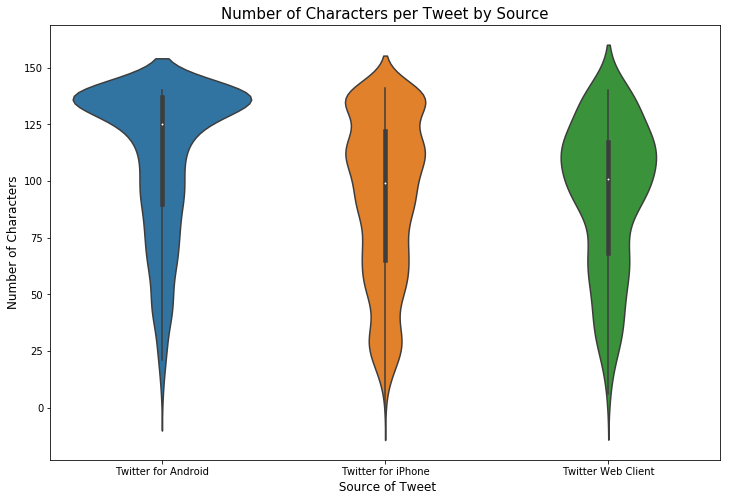

In [22]:
plt.figure(figsize=(12,8))
sns.violinplot(x=trump.source, y= 'num_char', data= trump)
plt.xlabel(' Source of Tweet', fontsize=12)
plt.ylabel('Number of Characters', fontsize=12)
plt.title('Number of Characters per Tweet by Source', fontsize=15)

Outliers on the low side of the charcter per tweet count might require another log function

In [23]:
trump['num_char']=trump['num_char'].apply(lambda x: np.log(x))

# Train_Test_Split

In [40]:
## Prepare target variable for model training with label encoding
le = LabelEncoder()
y = le.fit_transform(trump['source'])
X= trump.drop('source', axis=1)

In [41]:
X['is_retweet'] = le.fit_transform(X['is_retweet'])


In [42]:
le.classes_, y

(array([0, 1], dtype=int64), array([1, 2, 2, ..., 2, 2, 2], dtype=int64))

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3986, 13), (1709, 13), (3986,), (1709,))

## XGBoost

Let's perform XGBoost classifier on only the numerical variables.

In [27]:
numerical = [f for f in trump.columns if trump.dtypes[f] != 'object']
categorical = [f for f in trump.columns if trump.dtypes[f] == 'object']

print('The catergorical variables are: {}\nThe numerical variables are: {}'.format(str(categorical),str(numerical)))

The catergorical variables are: ['source', 'text', 'weekday']
The numerical variables are: ['favorite_count', 'is_retweet', 'retweet_count', 'hours', 'num_words', 'num_unique_words', 'num_char', 'num_stops', 'num_punc', 'num_upper', 'num_title']


In [43]:
# Define a function to calculate the xgboost classifier
def RunXGB(train_X, train_y, test_X,test_y, test_X2=None, seed_val=0, child=1, colsample=.3):
    param= {}
    param['objective'] = 'multi:softprob'
    param['eta'] = .1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = 'mlogloss'
    param['min_child_weight'] = child
    param['subsample'] = .8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000
    
    plist =list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label= test_y)
        watchlist = [ (xgtrain, 'train', xgtest, 'test') ]
        model = xgb.train(plist, xgtrain, num_rounds, watchlist, early_stopping_rounds =50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plist, xgtrain,num_rounds)
        
    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model


In [45]:
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores=[]
pred_full_test=0
pred_train= np.zeros([X[numerical].shape[0], 3])
for dev_index, val_index in kf.split(X[numerical]):
    dev_X, val_X =X[numerical].iloc[dev_index], X[numerical].iloc[val_index]
    dev_y, val_y = y[dev_index], y[val_index]
    pred_val_y, pred_test_y, model = runxgb(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('cv scores:', cv_scores)

[0]	train-mlogloss:1.05293	test-mlogloss:1.05403
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.722808	test-mlogloss:0.744164
[40]	train-mlogloss:0.644361	test-mlogloss:0.678602
[60]	train-mlogloss:0.607102	test-mlogloss:0.649383
[80]	train-mlogloss:0.582912	test-mlogloss:0.63427
[100]	train-mlogloss:0.564803	test-mlogloss:0.624435
[120]	train-mlogloss:0.551086	test-mlogloss:0.618704
[140]	train-mlogloss:0.538664	test-mlogloss:0.61569
[160]	train-mlogloss:0.527316	test-mlogloss:0.611495
[180]	train-mlogloss:0.516335	test-mlogloss:0.608638
[200]	train-mlogloss:0.507479	test-mlogloss:0.608236
[220]	train-mlogloss:0.499008	test-mlogloss:0.607149
[240]	train-mlogloss:0.491233	test-mlogloss:0.607381
[260]	train-mlogloss:0.482921	test-mlogloss:0.606952
[280]	train-mlogloss:0.474688	test-mlogloss:0.605663
[300]	train-mlogloss:0.467018	test-mlogloss:0.605555
[320]	train

ValueError: not enough values to unpack (expected 3, got 2)

In [47]:
runxgb(X_train[numerical], y_train, X_test[numerical], y_test, seed_val=0)

[0]	train-mlogloss:1.05928	test-mlogloss:1.06072
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.727864	test-mlogloss:0.74847
[40]	train-mlogloss:0.648713	test-mlogloss:0.680764
[60]	train-mlogloss:0.609257	test-mlogloss:0.651225
[80]	train-mlogloss:0.583889	test-mlogloss:0.632079
[100]	train-mlogloss:0.566221	test-mlogloss:0.623439
[120]	train-mlogloss:0.550558	test-mlogloss:0.616595
[140]	train-mlogloss:0.53796	test-mlogloss:0.611757
[160]	train-mlogloss:0.525696	test-mlogloss:0.606575
[180]	train-mlogloss:0.515006	test-mlogloss:0.604268
[200]	train-mlogloss:0.505075	test-mlogloss:0.601115
[220]	train-mlogloss:0.496212	test-mlogloss:0.598602
[240]	train-mlogloss:0.486929	test-mlogloss:0.597378
[260]	train-mlogloss:0.479183	test-mlogloss:0.597584
[280]	train-mlogloss:0.47065	test-mlogloss:0.595934
[300]	train-mlogloss:0.463541	test-mlogloss:0.593973
[320]	train-

(array([[ 0.00173616,  0.89682627,  0.10143755],
        [ 0.0050428 ,  0.93472373,  0.06023343],
        [ 0.00453637,  0.83582914,  0.15963446],
        ..., 
        [ 0.01395703,  0.02031825,  0.96572465],
        [ 0.00551128,  0.30730268,  0.687186  ],
        [ 0.05719016,  0.6436826 ,  0.29912722]], dtype=float32),
 <xgboost.core.Booster at 0x26eb0ff6400>)

So, with only the non-text based features we obtain a mean log loss of .42 for the training set and .59 for the test set.

NameError: name 'model' is not defined

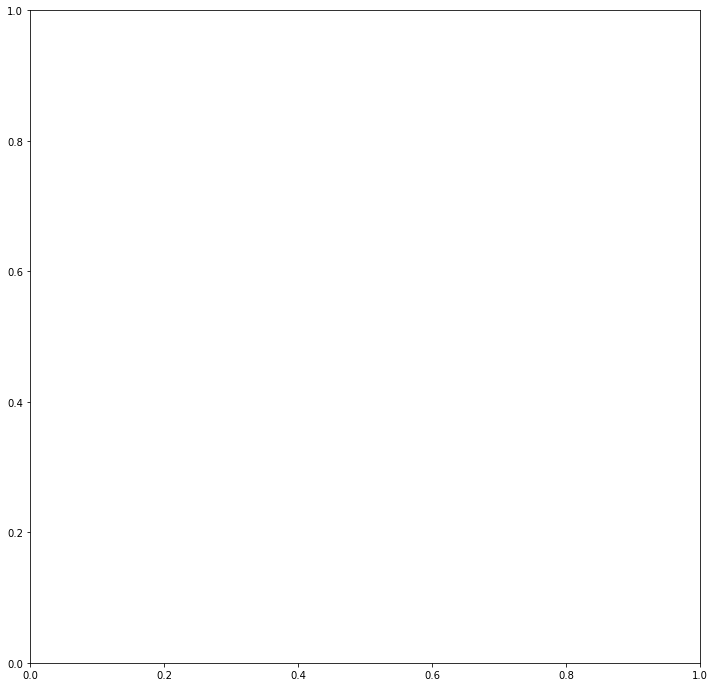

In [51]:
# Plot the feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model,height=.8, ax=ax)

## Text Based Attribute:


In [55]:
don = trump[trump['source']=='Twitter for Android']

In [57]:
analyser = SentimentIntensityAnalyzer()

com=[]
for idx, text in enumerate(trump.text):
    snt = analyser.polarity_scores(text)
    com.append(snt['compound'])
    

trump['com']=com

C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [58]:
don.head()

favorite_count  is_retweet  retweet_count  \
created_at                                                       
2016-01-01 00:44:14            6735           0           2108   
2016-01-01 06:08:06            7490           0           2721   
2016-01-01 21:29:56            3330           0            933   
2016-01-01 23:00:09            8495           0           2642   
2016-01-01 23:02:05            2780           0            654   

                                  source  \
created_at                                 
2016-01-01 00:44:14  Twitter for Android   
2016-01-01 06:08:06  Twitter for Android   
2016-01-01 21:29:56  Twitter for Android   
2016-01-01 23:00:09  Twitter for Android   
2016-01-01 23:02:05  Twitter for Android   

                                                                  text  hours  \
created_at                                                                      
2016-01-01 00:44:14  I will be on  live,  with members of my family...      0   
2016-01-01 06:08:06  " Hillary said she was in a "Fog of War" as ex...      6   
2016-01-01 21:29:56  "   they're spending millions but you're still...     21   
2016-01-01 23:00:09  Well, the year has officially begun. I have ma...     23   
2016-01-01 23:02:05      "  we love u to Trump Family. God bless you."     23   

                    weekday  num_words  num_unique_words  num_char  num_stops  \
created_at                                                                      
2016-01-01 00:44:14  Friday         25                24  4.804021         12   
2016-01-01 06:08:06  Friday         25                24  4.828314         11   
2016-01-01 21:29:56  Friday         14                14  4.356709          2   
2016-01-01 23:00:09  Friday         27                27  4.934474         14   
2016-01-01 23:02:05  Friday         10                10  3.806662          2   

                     num_punc  num_upper  num_title     com  
created_at                                                   
2016-01-01 00:44:14  1.945910          6          5  0.7519  
2016-01-01 06:08:06  1.945910          2          7 -0.8478  
2016-01-01 21:29:56  1.609438          0          2  0.7351  
2016-01-01 23:00:09  1.098612          1          2  0.6325  
2016-01-01 23:02:05  1.386294          0          3  0.8442

One of the first attributes that is important , to any Presidential election, is the overall sentiment of their tweets. The polarizing nature of the 2016 Election, along with Donald Trump's incessant use of Twitter, only makes this attribute more interesting. Python's NLTK VaderSentiment package attempts to interpret the sentiment from any blurb of text.

In [35]:

#instantiate vadersentiment and analyze tweets for negative, neutral, or positive sentiment.
#Calculate overall sentiment for tweet
analyser = SentimentIntensityAnalyzer()

neg=[]
neu=[]
pos=[]
com=[]
for idx, text in enumerate(X_train.text):
    snt = analyser.polarity_scores(text)
    com.append(snt['compound'])
    

X_train['com']=com

C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [36]:
analyser = SentimentIntensityAnalyzer()

neg=[]
neu=[]
pos=[]
com=[]
for idx, text in enumerate(X_test.text):
    snt = analyser.polarity_scores(text)
    com.append(snt['compound'])
    

X_test['com']=com

C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [37]:
X_train['com'][0:10]

created_at
2017-01-08 16:36:46    0.7495
2016-02-10 15:22:51    0.9229
2016-07-30 14:19:56    0.3595
2016-09-13 19:40:53    0.4199
2017-07-28 16:13:21    0.7940
2017-03-20 17:15:18    0.9109
2016-01-26 18:05:21    0.0000
2017-02-06 16:32:24   -0.7712
2016-07-02 21:13:02   -0.5974
2017-06-06 10:41:25    0.0000
Name: com, dtype: float64

In [38]:
X_test['com'][0:10]

created_at
2016-10-22 11:35:18    0.5859
2016-09-06 20:02:26    0.7430
2017-06-28 21:15:37    0.0000
2017-04-20 13:48:14   -0.7506
2017-09-03 16:14:31    0.2960
2016-12-10 11:19:24    0.7034
2017-02-17 11:43:10    0.5710
2017-05-30 13:59:28   -0.3016
2016-10-20 01:28:08   -0.8126
2016-01-21 23:29:43    0.4199
Name: com, dtype: float64

In [39]:
X_train.head()

favorite_count  is_retweet  retweet_count  \
created_at                                                       
2017-01-08 16:36:46           28740           0           5437   
2016-02-10 15:22:51           13599           0           3651   
2016-07-30 14:19:56           12800           0           4045   
2016-09-13 19:40:53           11283           0           2851   
2017-07-28 16:13:21           62365           0          13971   

                                  source  \
created_at                                 
2017-01-08 16:36:46  Twitter for Android   
2016-02-10 15:22:51  Twitter for Android   
2016-07-30 14:19:56   Twitter for iPhone   
2016-09-13 19:40:53   Twitter for iPhone   
2017-07-28 16:13:21   Twitter for iPhone   

                                                                  text  hours  \
created_at                                                                      
2017-01-08 16:36:46  " Welcome to President and Mrs. Bush.  \n Very...     16   
2016-02-10 15:22:51  So funny, Jeb Bush called me a "highly gifted ...     15   
2016-07-30 14:19:56  While I am in OH  PA - you can also join  in N...     14   
2016-09-13 19:40:53                           Thank you Clive, Iowa!\n     19   
2017-07-28 16:13:21  We will always ENFORCE our laws, PROTECT our b...     16   

                       weekday  num_words  num_unique_words  num_char  \
created_at                                                              
2017-01-08 16:36:46     Sunday          9                 9  3.931826   
2016-02-10 15:22:51  Wednesday         21                19  4.736198   
2016-07-30 14:19:56   Saturday         18                17  4.406719   
2016-09-13 19:40:53    Tuesday          4                 4  3.135494   
2017-07-28 16:13:21     Friday         18                16  4.875197   

                     num_stops  num_punc  num_upper  num_title     com  
created_at                                                              
2017-01-08 16:36:46          3  1.386294          0          5  0.7495  
2016-02-10 15:22:51          9  1.609438          1          4  0.9229  
2016-07-30 14:19:56          8  1.386294          3          7  0.3595  
2016-09-13 19:40:53          1  0.693147          0          3  0.4199  
2017-07-28 16:13:21          6  1.945910          5          3  0.7940

Obviously 0 compound score is an overall neutral tweet, positve is positive, and negative is negative.

## tf-idf

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english', ngram_range=(1,3))
X_train_counts = count_vect.fit_transform(X_train['text'])
X_train_counts.shape

count_vect.vocabulary_.get(u'algorithm')

In [60]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(3986, 57185)

In [61]:
X_train_df = pd.DataFrame(tf_transformer.transform(X_train_counts).todense(), columns = count_vect.get_feature_names())
X_train_df = pd.concat([X_train_df, X_train[numerical]], axis=1)

X_train_df.head()

C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\pandas\core\indexes\range.py:433: RuntimeWarning: Cannot compare type 'Timestamp' with type 'int', sort order is undefined for incomparable objects
  return self._int64index.union(other)


TypeError: 'NoneType' object is not iterable

In [52]:
X_train_df.fillna(0, inplace=True)

In [57]:
X_train_df.isnull().sum()

abandon                             0
abandon case                        0
abandon case disgraceful            0
abandon revolution                  0
abandon revolution welcome          0
abandoned                           0
abandoned supporters                0
abandoned supporters endorsing      0
abbas                               0
abc                                 0
abc agreed                          0
abc cbs                             0
abc cbs washpost                    0
abc debate                          0
abc debate unethical                0
abc dishonesty                      0
abc failing                         0
abc failing fake                    0
abc nbc                             0
abc nbc cbs                         0
abc nbc containing                  0
abc nbc polls                       0
abc news                            0
abc news debate                     0
abc news washington                 0
abdeslam                            0
abdeslam kne

In [58]:
X_train_df.shape, y_train.shape

((7972, 57195), (3986,))

In [55]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_df.values, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [66]:
X_new_counts = count_vect.transform(X_test['text'])
X_new_tfidf_df = tf_transformer.transform(X_new_counts)

In [67]:
yhat = clf.predict(X_new_tfidf)

for tweet, source in zip(X_test['text'], yhat):
    print('%r => %s' % (tweet, yhat[source]))

NameError: name 'clf' is not defined

In [182]:
yhat = pd.DataFrame(yhat)
yhat.shape

(1709, 1)

In [181]:
y_test=pd.DataFrame(y_test)
y_test.shape

(1709, 1)

In [184]:
np.mean(yhat == y_test)

0    0.661791
dtype: float64

In [204]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yhat, target_names = ['Web Client', 'Twitter for iPhone', 'Twitter for Android']))

                     precision    recall  f1-score   support

         Web Client       0.00      0.00      0.00       123
 Twitter for iPhone       0.76      0.36      0.49       627
Twitter for Android       0.64      0.94      0.76       959

        avg / total       0.64      0.66      0.61      1709



C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


tf-idf measures the frequency of each word within an individual text and the iverse of the frequency of each word within the entire document. 

In [159]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf.fit_transform( X_train['text'].values.tolist() + X_test['text'].values.tolist())
train_tfidf = tfidf.transform(X_train['text'].values.tolist())
test_tfidf = tfidf.transform(X_test['text'].values.tolist())



In [160]:
vocab = tfidf.get_feature_names()
len(vocab)

78401

In [161]:
test_tfidf.get_shape()

(1709, 78401)

In [210]:
X_train['weekday'] = le.fit_transform(X_train['weekday'])
X_test['weekday'] = le.transform(X_test['weekday'])

C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [213]:
X_train.drop('source', axis=1, inplace=True)
X_test.drop('source', axis=1, inplace=True)

C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [214]:
X_train.head()

favorite_count  is_retweet  retweet_count  \
created_at                                                       
2016-03-29 01:04:06           18228           0           5452   
2016-07-05 15:39:06           78067           0          40146   
2017-06-16 22:32:20           44120           0           9381   
2017-07-11 11:46:00          108873           0          20083   
2017-05-23 15:58:37          120808           0          30140   

                                                                  text  hours  \
created_at                                                                      
2016-03-29 01:04:06  Lyin' Ted, I have already beaten you in all de...      1   
2016-07-05 15:39:06  FBI director said Crooked Hillary compromised ...     15   
2017-06-16 22:32:20  "National Security Presidential Memorandum on ...     22   
2017-07-11 11:46:00  Working hard to get the Olympics for the Unite...     11   
2017-05-23 15:58:37  All civilized nations must join together to pr...     15   

                     weekday  num_words  num_unique_words  num_char  \
created_at                                                            
2016-03-29 01:04:06        5         27                24  4.934474   
2016-07-05 15:39:06        5         13                13  4.595120   
2017-06-16 22:32:20        0         15                14  4.762174   
2017-07-11 11:46:00        5         13                12  4.304065   
2017-05-23 15:58:37        5         24                21  4.875197   

                     num_stops  num_punc  num_upper  num_title     com  
created_at                                                              
2016-03-29 01:04:06         14  1.609438          1          4 -0.7712  
2016-07-05 15:39:06          2  1.386294          1          4  0.4926  
2017-06-16 22:32:20          4  0.693147          0         11  0.8126  
2017-07-11 11:46:00          4  1.791759          1          6  0.4003  
2017-05-23 15:58:37         10  0.000000          0          1  0.8779

We will perform a Multinomial Naive Bayes on the vectorized text

In [150]:
def runmnb(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y= model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [162]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([X_train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    pred_val_y, pred_test_y, model = runmnb(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.759034807949


In [127]:
### Function to create confusion matrix ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

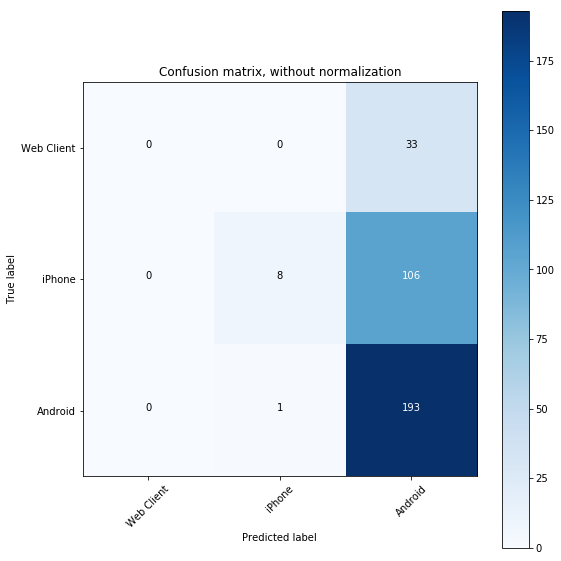

In [129]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['Web Client', 'iPhone', 'Android'],
                      title='Confusion matrix, without normalization')
plt.show()

In [116]:
runmnb(train_tfidf, y_train, test_tfidf,y_test)

(array([[ 0.04438647,  0.28496915,  0.67064439],
        [ 0.05409951,  0.24808497,  0.69781552],
        [ 0.04818222,  0.41899877,  0.53281901],
        ..., 
        [ 0.03438846,  0.18037319,  0.78523835],
        [ 0.04385065,  0.41237656,  0.54377279],
        [ 0.0184372 ,  0.29303669,  0.68852611]]),
 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))

In [108]:
yhat = model.predict(test_tfidf)
yhat.shape

(3987,)

In [111]:
yhat = yhat.reshape(-1,1)
yhat.shape

(3987, 1)

In [113]:
y_test.shape

(3987,)

In [114]:
model.score(yhat, y_test)

ValueError: shapes (3987,1) and (80676,3) not aligned: 1 (dim 1) != 80676 (dim 0)

## Numerical Variables

Let's start by investigating how the numerical relate with our target variable, the source of the tweet.

In [61]:
trump[numerical].head()

favorite_count  is_retweet  retweet_count
created_at                                                    
2016-01-01 00:44:14            6735       False           2108
2016-01-01 03:25:27            8581       False           3460
2016-01-01 05:18:23            9143       False           3434
2016-01-01 06:07:28            8258       False           1948
2016-01-01 06:08:06            7490       False           2721

In [54]:
trump['favorite_count'].describe()

count      5695.000000
mean      36305.056892
std       42046.904876
min           0.000000
25%        9334.500000
50%       19907.000000
75%       52275.000000
max      633253.000000
Name: favorite_count, dtype: float64

In [57]:
y.value_counts()

Twitter for iPhone     3221
Twitter for Android    2116
Twitter Web Client      358
Name: source, dtype: int64

In [60]:
trump.groupby('source')

KeyError: 'source'

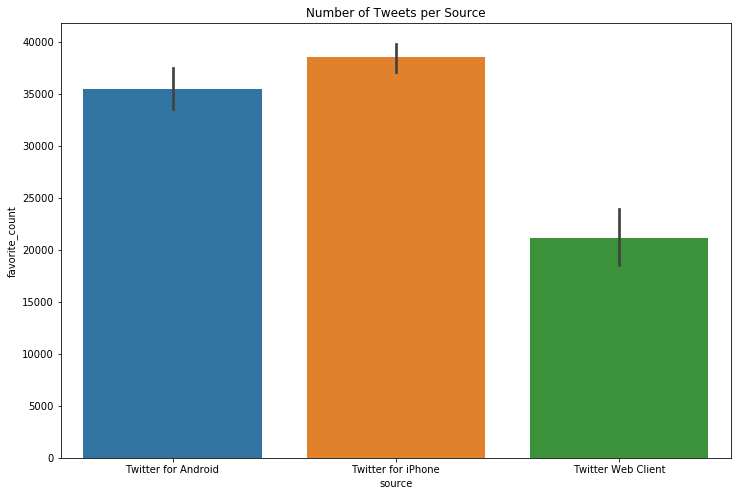

In [52]:
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.barplot(y='favorite_count', x=y, data=trump)
ax.set_title('Number of Likes per Source')



In [55]:
np.log(trump.favorite_count.values)

C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([  8.81507309,   9.05730574,   9.12074384, ...,  10.01332802,
         9.52493211,   9.38370527])

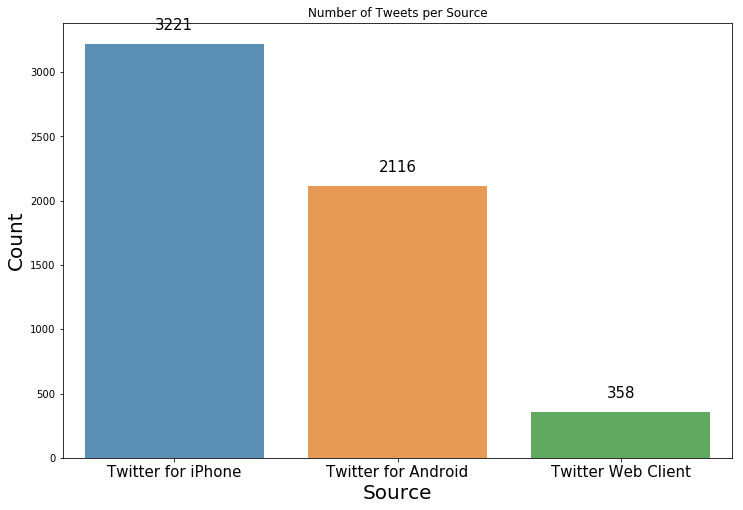

In [299]:
source = trump['source'].value_counts()
values = source.values

plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.barplot(source.index, source.values, alpha=.8)
ax.set_xlabel('Source', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('Number of Tweets per Source')
ax.set_xticklabels(source.index, fontsize=15)

rects = ax.patches

for rect, val in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 200, val, ha='center', va='top', fontsize=15)

In [133]:

mood = []
for idx,val in enumerate(trump['com']):
    if val < 0:
        mood.append('neg')
    elif val == 0:
        mood.append('neu')
    else:
        mood.append('pos')

trump['mood']=mood

Show any skewing in the data plotting a bar graph of the break down of the different sources of the tweets in the dataset.

In [180]:
trump.shape

(5717, 8)

In [219]:
trump.head()

favorite_count  is_retweet  retweet_count  \
created_at                                                       
2016-01-01 00:44:14            6735       False           2108   
2016-01-01 03:25:27            8581       False           3460   
2016-01-01 05:18:23            9143       False           3434   
2016-01-01 06:07:28            8258       False           1948   
2016-01-01 06:08:06            7490       False           2721   

                                  source  \
created_at                                 
2016-01-01 00:44:14  Twitter for Android   
2016-01-01 03:25:27   Twitter for iPhone   
2016-01-01 05:18:23   Twitter for iPhone   
2016-01-01 06:07:28   Twitter for iPhone   
2016-01-01 06:08:06  Twitter for Android   

                                                                  text  \
created_at                                                               
2016-01-01 00:44:14  I will be on  live,  with members of my family...   
2016-01-01 03:25:27                       HAPPY NEW YEAR  THANK YOU!     
2016-01-01 05:18:23                             #HappyNewYearAmerica!    
2016-01-01 06:07:28  Happy New Year from #MarALago! Thank you to my...   
2016-01-01 06:08:06  " Hillary said she was in a "Fog of War" as ex...   

                        com mood  hours weekday  
created_at                                       
2016-01-01 00:44:14  0.7519  pos      0  Friday  
2016-01-01 03:25:27  0.7574  pos      3  Friday  
2016-01-01 05:18:23  0.0000  neu      5  Friday  
2016-01-01 06:07:28  0.9230  pos      6  Friday  
2016-01-01 06:08:06 -0.8478  neg      6  Friday

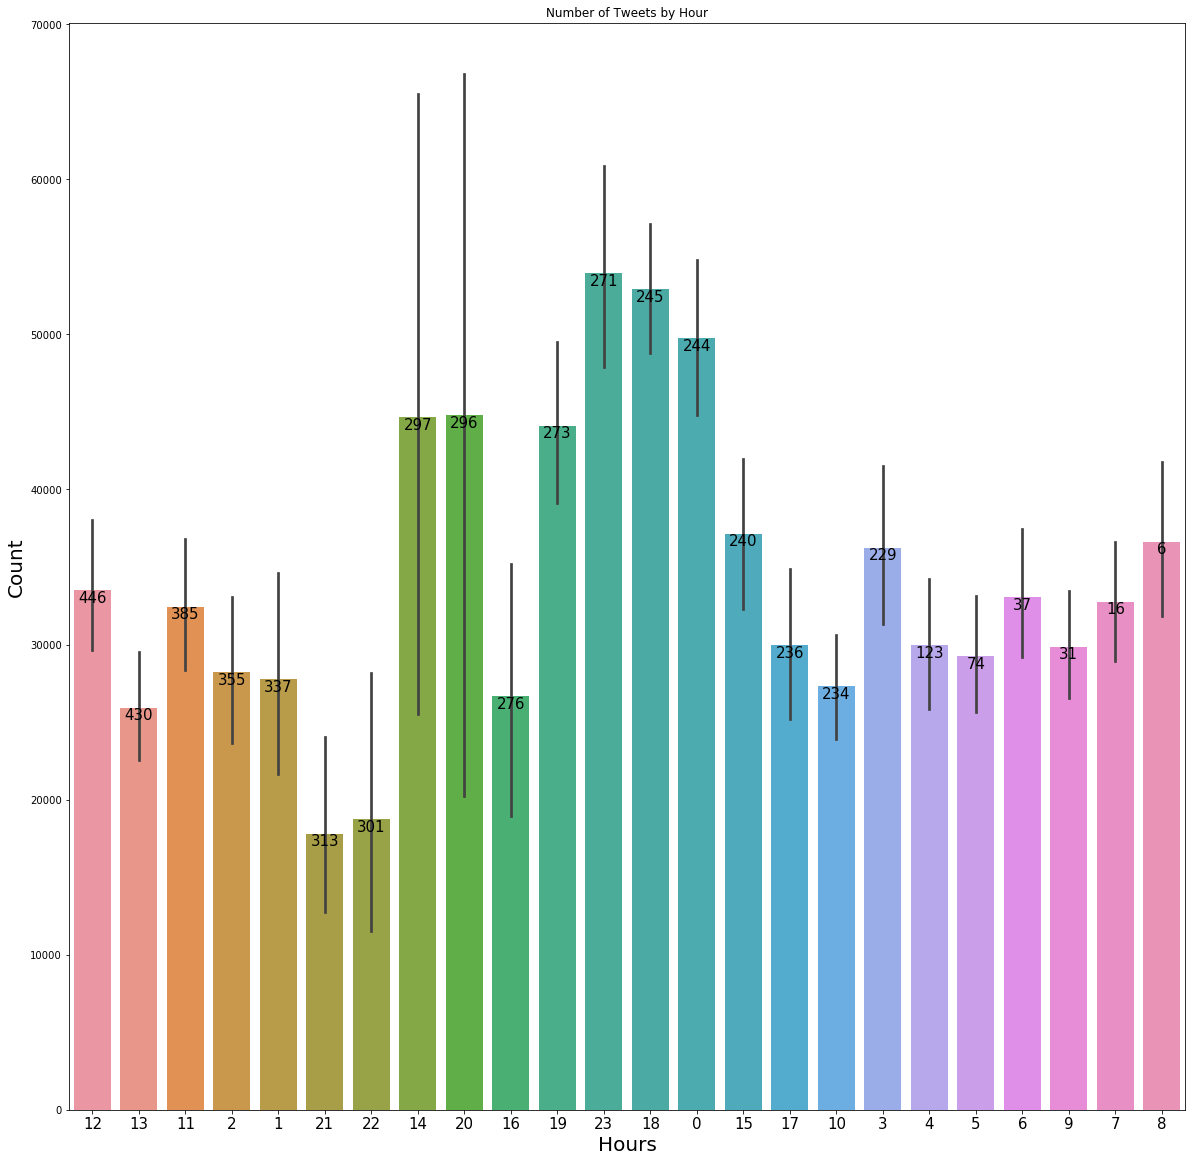

In [297]:
hour = trump['hours'].value_counts()
hr_values = hour.values

plt.figure(figsize=(20,20))
ax = plt.subplot()
sns.barplot(x='hours',y='favorite_count', data=trump)
ax.set_xlabel('Hours', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('Number of Tweets by Hour')
ax.set_xticklabels(hour.index, fontsize=15)

rects = ax.patches

for rect, val in zip(rects, hr_values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 2, val, ha='center', va='top', fontsize=15)

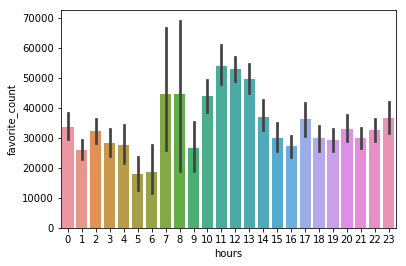

In [295]:
sns.barplot(x='hours',y='favorite_count', data=trump)


In [223]:
hour

12    447
13    430
11    386
2     357
1     337
21    317
22    305
14    298
20    297
16    276
19    273
23    271
0     248
18    246
15    240
17    237
10    234
3     231
4     123
5      74
6      37
9      31
7      16
8       6
Name: hours, dtype: int64

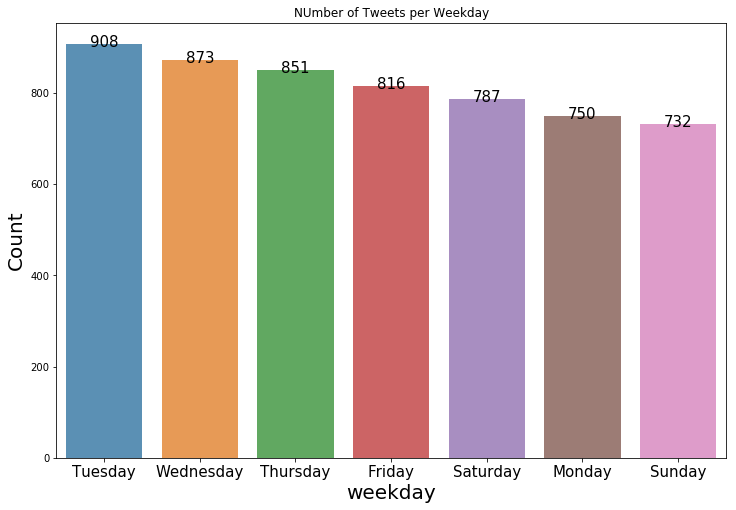

In [217]:
weekday = trump['weekday'].value_counts()
day_values = weekday.values

plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.barplot(weekday.index, weekday.values, alpha=.8)
ax.set_xlabel('weekday', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('Number of Tweets per Weekday')
ax.set_xticklabels(weekday.index, fontsize=15)

rects = ax.patches

for rect, val in zip(rects, day_values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 20, val, ha='center', va='top', fontsize=15)

In [258]:
week_grp = trump.groupby('weekday')['weekday', 'favorite_count'].sum()
week_grp

(7, 1)

In [281]:
hour_grp = trump.groupby('hours')[ 'favorite_count'].sum()
hour_grp

hours
0      8173242
1      8741314
2     11517849
3      6461475
4      3414425
5      1316657
6       693010
7       714588
8       268637
9       826565
10    10322864
11    20769262
12    23597948
13    21392874
14    11031964
15     7191940
16     7534309
17     8551829
18     7339524
19     7979615
20     9780345
21     9347718
22     9862456
23     9926889
Name: favorite_count, dtype: int64

In [282]:
df = pd.DataFrame(hour_grp)

In [283]:
df.reset_index( inplace=True)

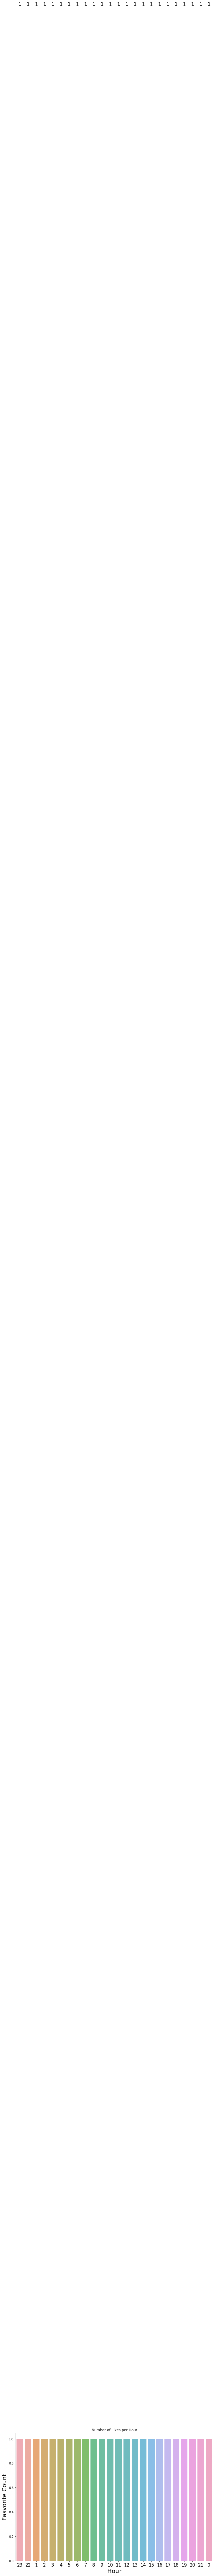

In [287]:
sns.barplot(x="hours", y="favorite_count", data=df)

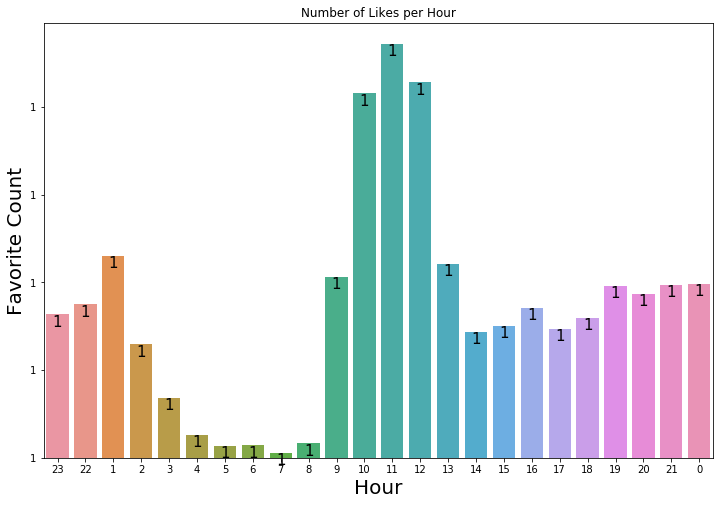

In [290]:
hours = df['hours'].value_counts()
hour_values = hours.values

plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.barplot(x='hours',y='favorite_count', data=df)
ax.set_xlabel('Hour', fontsize=20)
ax.set_ylabel('Favorite Count', fontsize=20)
ax.set_title('Number of Likes per Hour')
ax.set_xticklabels(hours.index, fontsize=10)
ax.set_yticklabels(hours.values, fontsize=10)

rects = ax.patches

for rect, val in zip(rects, hour_values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 20, val, ha='center', va='top', fontsize=15)

In [263]:
mood_grp = trump.groupby('mood')['favorite_count'].sum()
mood_grp

mood
neg     66570647
neu     27120999
pos    113065653
Name: favorite_count, dtype: int64

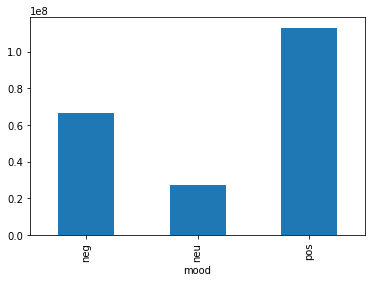

In [264]:
mood_grp.plot.bar()

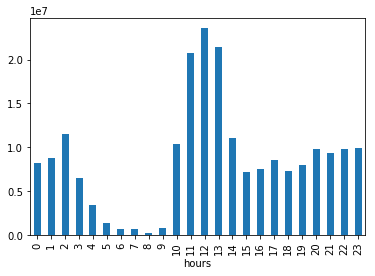

In [262]:
hour_grp.plot.bar()

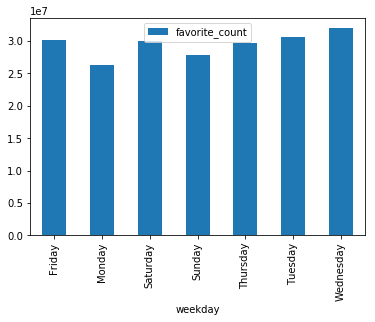

In [255]:
plt.figure(figsize=(20,16))
week_grp.plot.bar()

Exception: Data must be 1-dimensional

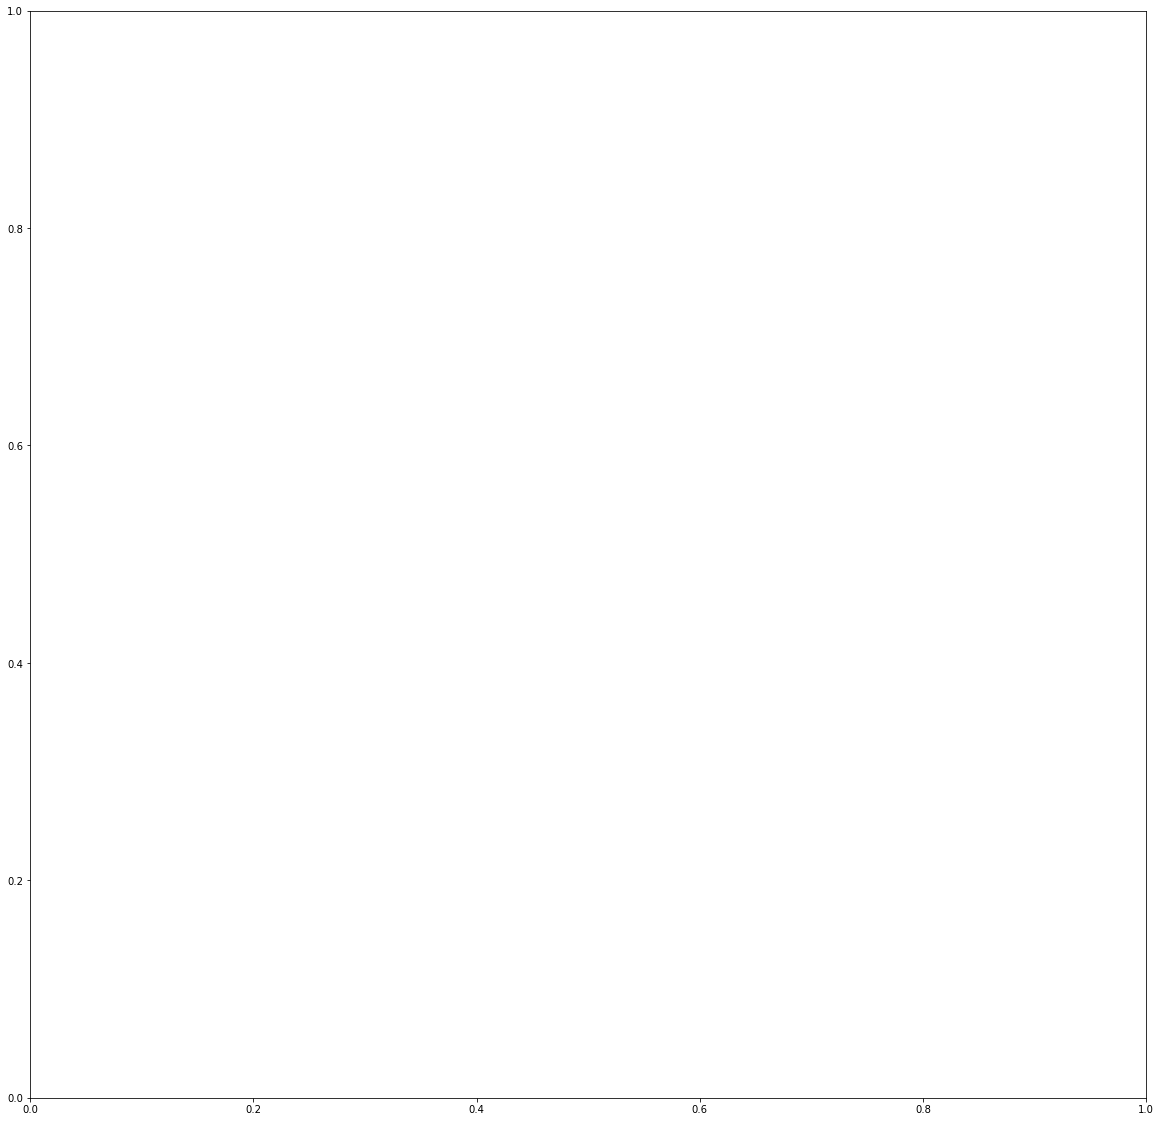

In [256]:

plt.figure(figsize=(20,20))
ax = plt.subplot()
sns.barplot(week_grp.index,week_grp.values, alpha=.8)
ax.set_xlabel('Weekday', fontsize=20)
ax.set_ylabel('Total Favorite Count', fontsize=20)
ax.set_title('Number of Likes per Day')
ax.set_xticklabels(week_grp.index, fontsize=15)


rects = ax.patches

for rect, val in zip(rects, wk_values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 2, val, ha='center', va='top', fontsize=15)

Let's investigate to see if the wrtiting styles of the different sources are different

In [193]:
sources_grp = trump.groupby('source')
for device, group in sources_grp:
    print('Device Name: ', device)
    count=0
    for ind , row in group.iterrows():
        print(row['text'])
        count +=1
        if count == 15:
            break
    print('\n')

Device Name:  Twitter Web Client
I look forward to being in Lowell, Massachusetts, today. I hear a very big crowd is expected--we will have lots of fun!
Woody Johnson, owner of the NYJets, is  finance chairman. If Woody would’ve been w/me, he would’ve been in the playoffs, at least!
Wow  circulation in NH has dropped from 75,000 to around 10—bad management. No wonder they begged me for ads.
I don’t know  to best of my knowledge haven't played golf w/him  think he does too many TV commercials—boring. Not a fan.
"  What's wrong with showing Morocco? Nothing! It illustrates a Point! Duh! Love the video!"
"   I love it when TRUMP calls out MSM for what they really are!  Cams starting to show crowds at rallies!"
I don’t cheat at golf but  cheats—with his game he has no choice—and stop doing commercials!
Don’t like  golf swing.  Not athletic. I’ve won many club championships. Play him for charity!
I will be on  for a  interview today. Please join us 5PM ET.
Massive crowd in VT tonight. Venue

In [214]:
trump.head()

favorite_count  is_retweet  retweet_count  \
created_at                                                       
2016-01-01 00:44:14            6735       False           2108   
2016-01-01 03:25:27            8581       False           3460   
2016-01-01 05:18:23            9143       False           3434   
2016-01-01 06:07:28            8258       False           1948   
2016-01-01 06:08:06            7490       False           2721   

                                  source  \
created_at                                 
2016-01-01 00:44:14  Twitter for Android   
2016-01-01 03:25:27   Twitter for iPhone   
2016-01-01 05:18:23   Twitter for iPhone   
2016-01-01 06:07:28   Twitter for iPhone   
2016-01-01 06:08:06  Twitter for Android   

                                                                  text  \
created_at                                                               
2016-01-01 00:44:14  I will be on  live,  with members of my family...   
2016-01-01 03:25:27                       HAPPY NEW YEAR  THANK YOU!     
2016-01-01 05:18:23                             #HappyNewYearAmerica!    
2016-01-01 06:07:28  Happy New Year from #MarALago! Thank you to my...   
2016-01-01 06:08:06  " Hillary said she was in a "Fog of War" as ex...   

                        com mood  hours weekday  
created_at                                       
2016-01-01 00:44:14  0.7519  pos      0  Friday  
2016-01-01 03:25:27  0.7574  pos      3  Friday  
2016-01-01 05:18:23  0.0000  neu      5  Friday  
2016-01-01 06:07:28  0.9230  pos      6  Friday  
2016-01-01 06:08:06 -0.8478  neg      6  Friday

In [17]:
# Convert text to lower case and split to individual words
trump.text = trump.text.apply(lambda x: x.lower())
trump.text = trump.text.apply(lambda x: len(x) w for w in x.split())

In [20]:
trump.head()

created_at  favorite_count              id_str  \
0 2016-01-01 00:44:14            6735  682723973449289728   
1 2016-01-01 03:25:27            8581  682764544402440192   
2 2016-01-01 05:18:23            9143  682792967736848384   
3 2016-01-01 06:07:28            8258  682805320217980928   
4 2016-01-01 06:08:06            7490  682805477168779264   

   in_reply_to_user_id_str  is_retweet  retweet_count               source  \
0                      NaN       False           2108  Twitter for Android   
1                      NaN       False           3460   Twitter for iPhone   
2                      NaN       False           3434   Twitter for iPhone   
3                      NaN       False           1948   Twitter for iPhone   
4                      NaN       False           2721  Twitter for Android   

                                                text    neg    neu    pos  \
0  [i, will, be, on, live,, with, members, of, my...  0.000  0.809  0.191   
1                    [happy, new, year, thank, you!]  0.000  0.316  0.684   
2                            [#happynewyearamerica!]  0.000  1.000  0.000   
3  [happy, new, year, from, #maralago!, thank, yo...  0.000  0.474  0.526   
4  [", hillary, said, she, was, in, a, "fog, of, ...  0.315  0.685  0.000   

      com  
0  0.7519  
1  0.7574  
2  0.0000  
3  0.9230  
4 -0.8478

In [21]:
#remove stop word from tweets
for idx,text in enumerate(trump.text):
    new_text=[]
    for word in text:
        if word not in english:
            new_text.append(word)
    trump.text[idx] = new_text
    

C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [24]:
trump.head()

created_at  favorite_count              id_str  \
0 2016-01-01 00:44:14            6735  682723973449289728   
1 2016-01-01 03:25:27            8581  682764544402440192   
2 2016-01-01 05:18:23            9143  682792967736848384   
3 2016-01-01 06:07:28            8258  682805320217980928   
4 2016-01-01 06:08:06            7490  682805477168779264   

   in_reply_to_user_id_str  is_retweet  retweet_count               source  \
0                      NaN       False           2108  Twitter for Android   
1                      NaN       False           3460   Twitter for iPhone   
2                      NaN       False           3434   Twitter for iPhone   
3                      NaN       False           1948   Twitter for iPhone   
4                      NaN       False           2721  Twitter for Android   

                                                text    neg    neu    pos  \
0  live, members family, 11:50 p.m. ring new year...  0.000  0.809  0.191   
1                          happy new year thank you!  0.000  0.316  0.684   
2                              #happynewyearamerica!  0.000  1.000  0.000   
3  happy new year #maralago! thank great family s...  0.000  0.474  0.526   
4  " hillary said "fog war" explanation lies beng...  0.315  0.685  0.000   

      com  
0  0.7519  
1  0.7574  
2  0.0000  
3  0.9230  
4 -0.8478

In [23]:
trump.text = trump.text.apply(lambda x: ' '.join(x))

In [25]:
don = trump[trump['source']=='Twitter for Android']
staff = trump[trump['source']=='Twitter for iPhone']

In [26]:
staff.head()

created_at  favorite_count              id_str  \
1  2016-01-01 03:25:27            8581  682764544402440192   
2  2016-01-01 05:18:23            9143  682792967736848384   
3  2016-01-01 06:07:28            8258  682805320217980928   
15 2016-01-02 03:32:13            7340  683128636279361536   
16 2016-01-02 04:17:23            6363  683140004625936384   

    in_reply_to_user_id_str  is_retweet  retweet_count              source  \
1                       NaN       False           3460  Twitter for iPhone   
2                       NaN       False           3434  Twitter for iPhone   
3                       NaN       False           1948  Twitter for iPhone   
15                      NaN       False           3057  Twitter for iPhone   
16                      NaN       False           2145  Twitter for iPhone   

                                                 text  neg    neu    pos  \
1                           happy new year thank you!  0.0  0.316  0.684   
2                               #happynewyearamerica!  0.0  1.000  0.000   
3   happy new year #maralago! thank great family s...  0.0  0.474  0.526   
15  #votetrump2016 together #makeamericagreatagain...  0.0  0.551  0.449   
16  massive crowds expected mississippi tomorrow n...  0.0  1.000  0.000   

       com  
1   0.7574  
2   0.0000  
3   0.9230  
15  0.7592  
16  0.0000

In [27]:
don.head()

created_at  favorite_count              id_str  \
0 2016-01-01 00:44:14            6735  682723973449289728   
4 2016-01-01 06:08:06            7490  682805477168779264   
5 2016-01-01 21:29:56            3330  683037464504745984   
6 2016-01-01 23:00:09            8495  683060169677344768   
7 2016-01-01 23:02:05            2780  683060654098530304   

   in_reply_to_user_id_str  is_retweet  retweet_count               source  \
0                      NaN       False           2108  Twitter for Android   
4                      NaN       False           2721  Twitter for Android   
5                      NaN       False            933  Twitter for Android   
6                      NaN       False           2642  Twitter for Android   
7                      NaN       False            654  Twitter for Android   

                                                text    neg    neu    pos  \
0  live, members family, 11:50 p.m. ring new year...  0.000  0.809  0.191   
4  " hillary said "fog war" explanation lies beng...  0.315  0.685  0.000   
5  " they're spending millions you're still going...  0.000  0.679  0.321   
6  well, year officially begun. many stops planne...  0.104  0.693  0.203   
7             " love u trump family. god bless you."  0.000  0.355  0.645   

      com  
0  0.7519  
4 -0.8478  
5  0.7351  
6  0.6325  
7  0.8442

In [28]:
don.shape, staff.shape

((2116, 12), (3221, 12))

In [49]:
fig = plt.figure(figsize=(12,8))
plt.plot(don['com'], don['retweet_count'])
plt.xticks(0,1)
plt.yticks(0, don['retweet_count'].max())
plt.show()

TypeError: object of type 'int' has no len()

favorite_count        id_str  in_reply_to_user_id_str  \
neg   neu   pos                                                            
0.000 0.000 0.000         18917.0  2.109312e+18                      NaN   
      0.109 0.891          7144.0  7.405171e+17                      NaN   
      0.122 0.878         14496.0  7.226287e+17                      NaN   
      0.204 0.796         27688.0  7.101779e+17                      NaN   
      0.208 0.792          4969.0  7.327366e+17                      NaN   
      0.222 0.778         14219.0  7.277095e+17                      NaN   
      0.247 0.753         15681.0  7.787593e+17                      NaN   
      0.264 0.736        199748.0  1.615692e+18                      NaN   
      0.274 0.726         19522.0  7.012402e+17                      NaN   
      0.291 0.709          5286.0  7.327297e+17                      NaN   
      0.296 0.704          4341.0  6.902727e+17                      NaN   
      0.300 0.700          4815.0  7.327333e+17                      NaN   
      0.302 0.698         17388.0  7.645538e+17                      NaN   
      0.309 0.691          4856.0  7.327261e+17                      NaN   
      0.310 0.690          8110.0  7.407073e+17                      NaN   
      0.313 0.687          6112.0  7.353450e+17                      NaN   
      0.314 0.686          7844.0  7.353460e+17                      NaN   
      0.328 0.672         22422.0  1.516210e+18                      NaN   
      0.338 0.662          8087.0  7.195005e+17                      NaN   
      0.339 0.661          6807.0  7.353454e+17                      NaN   
      0.342 0.658          2665.0  6.867530e+17                      NaN   
      0.343 0.657         24061.0  1.444111e+18                      NaN   
      0.349 0.651         31863.0  1.528942e+18                      NaN   
      0.353 0.647         26589.0  1.506569e+18                      NaN   
      0.354 0.646         21252.0  7.373768e+17                      NaN   
      0.355 0.645          2780.0  6.830607e+17                      NaN   
      0.373 0.627          3149.0  6.842188e+17                      NaN   
      0.380 0.620          9323.0  7.182689e+17                      NaN   
      0.382 0.618        275033.0  1.547862e+18                      NaN   
      0.385 0.615         24854.0  7.606693e+17                      NaN   
...                           ...           ...                      ...   
0.438 0.524 0.038         27046.0  7.772803e+17                      NaN   
0.439 0.462 0.099         84723.0  8.207641e+17                      NaN   
0.440 0.560 0.000        248568.0  2.401790e+18                      NaN   
0.443 0.475 0.081         26857.0  7.762691e+17                      NaN   
0.444 0.403 0.153         12502.0  6.999688e+17                      NaN   
      0.556 0.000         38018.0  1.470375e+18                      NaN   
0.447 0.553 0.000         14397.0  7.104096e+17                      NaN   
0.448 0.552 0.000         16189.0  7.130069e+17                      NaN   
0.449 0.551 0.000        166517.0  1.567578e+18                      NaN   
0.450 0.478 0.072         46998.0  7.115866e+17                      NaN   
0.452 0.369 0.179        108710.0  8.353258e+17                      NaN   
0.455 0.315 0.230         14700.0  7.691852e+17                      NaN   
0.456 0.544 0.000         13308.0  7.834806e+17                      NaN   
0.463 0.537 0.000             2.0  8.289374e+17                      NaN   
0.466 0.420 0.114         25376.0  7.315034e+17                      NaN   
0.467 0.533 0.000         53145.0  7.568049e+17                      NaN   
0.478 0.522 0.000          3844.0  6.927005e+17                      NaN   
0.484 0.330 0.187         10243.0  6.998025e+17                      NaN   
      0.516 0.000         21527.0  7.590241e+17                      NaN   
0.485 0.441 0.074         14751.0  7.068126e+17                    

In [36]:
don[don['com'] >= 0].count()

created_at                 1315
favorite_count             1315
id_str                     1315
in_reply_to_user_id_str       2
is_retweet                 1315
retweet_count              1315
source                     1315
text                       1315
neg                        1315
neu                        1315
pos                        1315
com                        1315
dtype: int64

In [33]:
neg

favorite_count             1666
id_str                     1666
in_reply_to_user_id_str      13
is_retweet                 1666
retweet_count              1666
source                     1666
text                       1666
neg                        1666
neu                        1666
pos                        1666
com                        1666
dtype: int64

In [61]:
don.head()

favorite_count  is_retweet  retweet_count  \
created_at                                                       
2016-01-01 00:44:14            6735           0           2108   
2016-01-01 06:08:06            7490           0           2721   
2016-01-01 21:29:56            3330           0            933   
2016-01-01 23:00:09            8495           0           2642   
2016-01-01 23:02:05            2780           0            654   

                                  source  \
created_at                                 
2016-01-01 00:44:14  Twitter for Android   
2016-01-01 06:08:06  Twitter for Android   
2016-01-01 21:29:56  Twitter for Android   
2016-01-01 23:00:09  Twitter for Android   
2016-01-01 23:02:05  Twitter for Android   

                                                                  text  hours  \
created_at                                                                      
2016-01-01 00:44:14  I will be on  live,  with members of my family...      0   
2016-01-01 06:08:06  " Hillary said she was in a "Fog of War" as ex...      6   
2016-01-01 21:29:56  "   they're spending millions but you're still...     21   
2016-01-01 23:00:09  Well, the year has officially begun. I have ma...     23   
2016-01-01 23:02:05      "  we love u to Trump Family. God bless you."     23   

                    weekday  num_words  num_unique_words  num_char  num_stops  \
created_at                                                                      
2016-01-01 00:44:14  Friday         25                24  4.804021         12   
2016-01-01 06:08:06  Friday         25                24  4.828314         11   
2016-01-01 21:29:56  Friday         14                14  4.356709          2   
2016-01-01 23:00:09  Friday         27                27  4.934474         14   
2016-01-01 23:02:05  Friday         10                10  3.806662          2   

                     num_punc  num_upper  num_title     com  
created_at                                                   
2016-01-01 00:44:14  1.945910          6          5  0.7519  
2016-01-01 06:08:06  1.945910          2          7 -0.8478  
2016-01-01 21:29:56  1.609438          0          2  0.7351  
2016-01-01 23:00:09  1.098612          1          2  0.6325  
2016-01-01 23:02:05  1.386294          0          3  0.8442

In [62]:
#resample for daily time period, Calculate sentiment for all tweets per day
trump_sent = pd.DataFrame(don.resample('D')['com'].sum())

trump_sent.to_csv(trump_sent.csv')

In [66]:
trump_sent = pd.DataFrame(trump.resample('D').sum())
trump_sent.shape

(625, 11)

In [64]:
don_sent.shape

(450, 1)

In [21]:
trump_sent.head()

com
created_at        
2016-01-01  6.4942
2016-01-02  2.8296
2016-01-03  0.1894
2016-01-04  2.0465
2016-01-05  8.0538